<a href="https://colab.research.google.com/github/pachterlab/kb_docs/blob/main/docs/source/lr/notebooks/general.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lr-kallisto single-nuclei data analysis tutorial
### Processing ONT single-nuclei data, starting with seqspec and using splitcode for extraction
#### [Open in Google Colab](https://colab.research.google.com/github/pachterlab/kb_docs/blob/main/docs/source/lr/notebooks/general.ipynb)

In [ ]:
!git clone https://github.com/pachterlab/splitcode
!cd splitcode; mkdir build; cd build; cmake ..; make; make install

Cloning into 'splitcode'...
remote: Enumerating objects: 2833, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 2833 (delta 132), reused 197 (delta 111), pack-reused 2603 (from 1)
Receiving objects: 100% (2833/2833), 15.76 MiB | 20.61 MiB/s, done.
Resolving deltas: 100% (1557/1557), done.
CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- 

In [ ]:
#show splitcode version
!splitcode/build/src/splitcode --version

splitcode, version 0.30.0


In [ ]:
#Get example data and seqspec with supporting on-list files and configs for barcode correction and merging that is SPLiT-Seq specific
!wget https://zenodo.org/records/13947934/files/lr-kallisto_example.tar.gz

--2024-10-25 18:21:17--  https://zenodo.org/records/13947934/files/lr-kallisto_example.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183118684 (175M) [application/octet-stream]
Saving to: ‘lr-kallisto_example.tar.gz’

lr-kallisto_example 100%[===================>] 174.63M  31.1MB/s    in 6.2s    

2024-10-25 18:21:24 (28.0 MB/s) - ‘lr-kallisto_example.tar.gz’ saved [183118684/183118684]



In [ ]:
#uncompress folder
!tar -xvf lr-kallisto_example.tar.gz
!cp lr-kallisto_example/r*txt .

lr-kallisto_example/
lr-kallisto_example/spec.yaml
lr-kallisto_example/13G-gc_5W.fastq.gz
lr-kallisto_example/config.mergeRT
lr-kallisto_example/r2_3.txt
lr-kallisto_example/config_RT_randO.txt
lr-kallisto_example/config-correct.txt
lr-kallisto_example/config_RT_polyT.txt
lr-kallisto_example/r1_R.txt
lr-kallisto_example/r1_T.txt


In [ ]:
#Install seqspec
!pip install git+https://github.com/pachterlab/seqspec

!seqspec index -m rna -s file -t splitcode lr-kallisto_example/spec.yaml > ONT.config

  Cloning https://github.com/pachterlab/seqspec to /tmp/pip-req-build-74o45k5g
  Running command git clone --filter=blob:none --quiet https://github.com/pachterlab/seqspec /tmp/pip-req-build-74o45k5g
  Resolved https://github.com/pachterlab/seqspec to commit 1475ff00eac673af900d9be4fb36f23716058da4
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 76.5 MB/s eta 0:00:00
  Created wheel for seqspec: filename=seqspec-0.3.1-py3-none-any.whl size=47739 sha256=e34bb2aba1bd74bc68ea9195bd9f9e7166aaafc260a437d37eb16329a48a5bb1
  Stored in directory: /tmp/pip-ephem-wheel-cache-wp2iswh_/wheels/a3/4d/76/1e56215ad56c936bb0c24c4be01c5e8f7aeb0af528d415423c
Successfully built seqspec


In [ ]:
#Make config less error tolerant, allowing one error instead of 3 errors
!sed -i 's/3:3:3/1:1:1/g' ONT.config

In [ ]:
#extract barcodes, cDNAs, and umis
!splitcode/build/src/splitcode -c ONT.config -t 2 lr-kallisto_example/13G-gc_5W.fastq.gz -o igvfb01_13G_scmodified/igvfb01_13G_5W.fastq.gz

* Forcing --gzip because all output file names end in .gz
* Using a list of 8 tags (vector size: 8; map size: 6,286; num elements in map: 6,344)
* will process sample 1: lr-kallisto_example/13G-gc_5W.fastq.gz
* processing the reads ...
done 
* processed 268,542 reads


In [ ]:
import os

samples = [''] #,'13G']


for sample in samples:
    files_f = [sample+'f', sample+'c']
    files_r = [sample+'r', sample+'rc']

    for f in files_r+files_f:
        for fastq in ["barcode", "cDNA", "umi"]:
            os.system("gunzip -f "+f+"_"+fastq+".fastq.gz")

    c = 0
    writelines = ""
    fastqc=open(sample+'c_barcode.fastq', 'r')
    ofastqc=open(sample+'c_barcode.tmp.fastq', 'w+')
    for l in fastqc.readlines():
        c+=1
        if l.startswith("@") or l.startswith("+"):
            writelines+=l
        elif l != "\n":
            writelines+=l[0:8][::-1]+l[8:16][::-1]+l[16:24][::-1]+"\n"
        else:
            writelines+=l
        if c == 4:
            ofastqc.write(writelines)
            c = 0
            writelines = ""
    fastqc.close()
    ofastqc.close()
    os.system("mv "+sample+'c_barcode.tmp.fastq '+sample+'c_barcode.fastq')

    fastqc=open(sample+'r_barcode.fastq', 'r')
    ofastqc=open(sample+'r_barcode.tmp.fastq', 'w+')
    for l in fastqc.readlines():
        c+=1
        if l.startswith("@") or l.startswith("+"):
            writelines+=l
        elif l != "\n":
            writelines+=l[::-1]+"\n"
        else:
            writelines+=l
        if c == 4:
            ofastqc.write(writelines)
            c = 0
            writelines = ""
    fastqc.close()
    ofastqc.close()
    os.system("mv "+sample+'r_barcode.tmp.fastq '+sample+'r_barcode.fastq')

    c = 0
    writelines = ""
    fastqc=open(sample+'rc_barcode.fastq', 'r')
    ofastqc=open(sample+'rc_barcode.tmp.fastq', 'w+')
    for l in fastqc.readlines():
        c+=1
        if l.startswith("@") or l.startswith("+"):
            writelines+=l
        elif l != "\n":
            writelines+=l[16:24]+l[8:16]+l[0:8]+"\n"
        else:
            writelines+=l
        if c == 4:
            ofastqc.write(writelines)
            c = 0
            writelines = ""
    fastqc.close()
    ofastqc.close()
    os.system("mv "+sample+'rc_barcode.tmp.fastq '+sample+'rc_barcode.fastq')


    for fastq in ["barcode", "cDNA", "umi"]:
        cmd = "cat "
        for f in files_f+files_r:
            cmd += f+'_'+fastq+'.fastq '
        cmd += '> '+sample+'_'+fastq+'.fastq'
        print(cmd)
        os.system(cmd)

cat f_barcode.fastq c_barcode.fastq r_barcode.fastq rc_barcode.fastq > _barcode.fastq
cat f_cDNA.fastq c_cDNA.fastq r_cDNA.fastq rc_cDNA.fastq > _cDNA.fastq
cat f_umi.fastq c_umi.fastq r_umi.fastq rc_umi.fastq > _umi.fastq


In [ ]:
#correct barcodes
!splitcode/build/src/splitcode -c lr-kallisto_example/config-correct.txt --nFastqs=2 --select=0 --gzip -o 13G_cDNA.fastq.gz _cDNA.fastq _barcode.fastq -t 2;

!splitcode/build/src/splitcode -c lr-kallisto_example/config-correct.txt --nFastqs=2 --select=0 --gzip -o 13G_umi.fastq.gz _umi.fastq _barcode.fastq -t 2;

#merge randO and polyT
!splitcode/build/src/splitcode -c lr-kallisto_example/config.mergeRT -o 13G_barcode.fastq 13G_barcode.fastq.gz -t 2;

* Using a list of 384 tags (vector size: 384; map size: 32,059; num elements in map: 42,792)
* will process sample 1: _cDNA.fastq
                         _barcode.fastq
* processing the reads ...
done 
* processed 1,074,168 reads
* Using a list of 384 tags (vector size: 384; map size: 32,059; num elements in map: 42,792)
* will process sample 1: _umi.fastq
                         _barcode.fastq
* processing the reads ...
done 
* processed 1,074,168 reads
* Using a list of 96 tags (vector size: 96; map size: 2,989; num elements in map: 3,168)
* will process sample 1: 13G_barcode.fastq.gz
* processing the reads ...
done 
* processed 23,977 reads


In [ ]:
#correct barcodes and extract only polyT
!splitcode/build/src/splitcode -c lr-kallisto_example/config_RT_polyT.txt --nFastqs=2 --select=0 --gzip -o 13G_cDNA_polyT.fastq.gz 13G_cDNA.fastq.gz 13G_barcode.fastq.gz -t 2;

!splitcode/build/src/splitcode -c lr-kallisto_example/config_RT_polyT.txt --nFastqs=2 --select=0 --gzip -o 13G_umi_polyT.fastq.gz 13G_umi.fastq.gz 13G_barcode.fastq.gz -t 2;

* Using a list of 288 tags (vector size: 288; map size: 22,690; num elements in map: 31,560)
* will process sample 1: 13G_cDNA.fastq.gz
                         13G_barcode.fastq.gz
* processing the reads ...
done 
* processed 23,977 reads
* Using a list of 288 tags (vector size: 288; map size: 22,690; num elements in map: 31,560)
* will process sample 1: 13G_umi.fastq.gz
                         13G_barcode.fastq.gz
* processing the reads ...
done 
* processed 23,977 reads


In [ ]:
#correct barcodes and extract only randO
!splitcode/build/src/splitcode -c lr-kallisto_example/config_RT_randO.txt --nFastqs=2 --select=0 --gzip -o 13G_cDNA_randO.fastq.gz 13G_cDNA.fastq.gz 13G_barcode.fastq.gz -t 2;

!splitcode/build/src/splitcode -c lr-kallisto_example/config_RT_randO.txt --nFastqs=2 --select=0 --gzip -o 13G_umi_randO.fastq.gz 13G_umi.fastq.gz 13G_barcode.fastq.gz -t 2;

* Using a list of 288 tags (vector size: 288; map size: 22,913; num elements in map: 31,647)
* will process sample 1: 13G_cDNA.fastq.gz
                         13G_barcode.fastq.gz
* processing the reads ...
done 
* processed 23,977 reads
* Using a list of 288 tags (vector size: 288; map size: 22,913; num elements in map: 31,647)
* will process sample 1: 13G_umi.fastq.gz
                         13G_barcode.fastq.gz
* processing the reads ...
done 
* processed 23,977 reads


In [ ]:
#install gget and kb
!pip install -q kb_python gget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 49.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.5/36.5 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 k

In [ ]:
#download reference for mouse with k-mer size 31 or 63
!kb ref -k 31 -d mouse -i mouse_k-31.idx -g mouse.t2g
!kb ref -k 63 -d mouse -i mouse_k-63.idx -g mouse.t2g
#alternatively build your own
'''
!kb ref -k 63\
    -i mouse_k-63.idx \
    -g t2g.txt \
    -f1 fasta.fa \
    $(gget ref --ftp -w dna,gtf mouse)
'''

[2024-10-25 18:35:34,749]    INFO [download] Downloading files for mouse (standard workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/mouse_index_standard.tar.xz to tmp/mouse_index_standard.tar.xz
100% 82.8M/82.8M [00:01<00:00, 81.3MB/s]
[2024-10-25 18:35:35,827]    INFO [download] Extracting files from tmp/mouse_index_standard.tar.xz
[2024-10-25 18:36:16,725]    INFO [download] Downloading files for mouse (standard workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/mouse_index_standard_long.tar.xz to tmp/mouse_index_standard_long.tar.xz
100% 74.8M/74.8M [00:01<00:00, 74.2MB/s]
[2024-10-25 18:36:17,785]    INFO [download] Extracting files from tmp/mouse_index_standard_long.tar.xz


'\n!kb ref -k 63    -i mouse_k-63.idx     -g t2g.txt     -f1 fasta.fa     $(gget ref --ftp -w dna,gtf mouse)\n'

In [ ]:
#Use kb count to pseudoalign and produce count matrices
!kb count -k 63 --long --threshold 0.8 -i mouse_k-63.idx -g mouse.t2g -o output -x '2,0,24:1,0,10:0,0,0' 13G_cDNA.fastq.gz 13G_umi.fastq.gz 13G_barcode.fastq
!kb count -k 63 --long --threshold 0.8 -i mouse_k-63.idx -g mouse.t2g -o output_randO -x '2,0,24:1,0,10:0,0,0' 13G_cDNA_randO.fastq.gz 13G_umi_randO.fastq.gz 13G_barcode_randO.fastq.gz
!kb count -k 63 --long --threshold 0.8 -i mouse_k-63.idx -g mouse.t2g -o output_polyT -x '2,0,24:1,0,10:0,0,0' 13G_cDNA_polyT.fastq.gz 13G_umi_polyT.fastq.gz 13G_barcode_polyT.fastq.gz

[2024-10-25 18:37:10,815]    INFO [count] Using index mouse_k-63.idx to generate BUS file to output from
[2024-10-25 18:37:10,815]    INFO [count]         13G_cDNA.fastq.gz
[2024-10-25 18:37:10,815]    INFO [count]         13G_umi.fastq.gz
[2024-10-25 18:37:10,815]    INFO [count]         13G_barcode.fastq
[2024-10-25 18:39:00,697]    INFO [count] Sorting BUS file output/output.bus to output/tmp/output.s.bus
[2024-10-25 18:39:04,925]    INFO [count] On-list not provided
[2024-10-25 18:39:04,926]    INFO [count] Generating on-list output/whitelist.txt from BUS file output/tmp/output.s.bus
[2024-10-25 18:39:06,029]    INFO [count] Inspecting BUS file output/tmp/output.s.bus
[2024-10-25 18:39:07,135]    INFO [count] Correcting BUS records in output/tmp/output.s.bus to output/tmp/output.s.c.bus with on-list output/whitelist.txt
[2024-10-25 18:39:09,942]    INFO [count] Sorting BUS file output/tmp/output.s.c.bus to output/output.unfiltered.bus
[2024-10-25 18:39:13,963]    INFO [count] Gener

In [ ]:
# Import packages and read in count matrix from polyT
import scipy
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io
import seaborn as sns

matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'
# import data
dir = 'output_polyT/counts_unfiltered' #'b01_nanopore_13G_single_cell'#'b01_nanopore_13G__sc_single_cell'
adata = sc.read_mtx(dir+"/cells_x_genes.mtx")
adata.obs.index = pd.read_csv(dir+"/cells_x_genes.barcodes.txt", header=None)[0].values
adata.var.index = pd.read_csv(dir+"/cells_x_genes.genes.names.txt", header=None)[0].values


In [ ]:
#Read in merged polyT and randO matrix
dir = 'output/counts_unfiltered' #'b01_nanopore_13G_single_cell'#'b01_nanopore_13G__sc_single_cell'
Iadata = sc.read_mtx(dir+"/cells_x_genes.mtx")
Iadata.obs.index = pd.read_csv(dir+"/cells_x_genes.barcodes.txt", header=None)[0].values
Iadata.var.index = pd.read_csv(dir+"/cells_x_genes.genes.names.txt", header=None)[0].values


In [ ]:
adata.var

""
Gm15178
Gm29155
C730036E19Rik
Gm29157
Gm29156
...
ENSMUSG00000095019.2
ENSMUSG00000094915.2
ENSMUSG00000079808.4
ENSMUSG00000095041.8


In [ ]:
Iadata.var

""
Gm15178
Gm29155
C730036E19Rik
Gm29157
Gm29156
...
ENSMUSG00000095019.2
ENSMUSG00000094915.2
ENSMUSG00000079808.4
ENSMUSG00000095041.8


In [ ]:
Iadata.obs

""
AAACATCGAACTCACCTCTCATGC
AAACATCGAAGAGATCTCATTGCA
AAACATCGACACAGAAATCCTTAC
AAACATCGACAGATTCACTGCTCT
AAACATCGACAGATTCCATACTTC
...
TTCACGCAGAATCTGATCATTGCA
TTCACGCAGATAGACAGCCTATCT
TTCACGCAGCTAACGAACTGCTCT
TTCACGCAGTCTGTCATTATTCTG


In [ ]:
adata.obs

""
AAACATCGACACAGAAACTGCTCT
AAACATCGACAGATTCACTGCTCT
AAACATCGACAGATTCCATACTTC
AAACATCGAGAGTCAAACATTTAC
AAACATCGAGATGTACATTTGGCA
...
TTCACGCACGCTGATCACTGCTCT
TTCACGCAGAACAGGCGCTATCAT
TTCACGCAGATAGACAGCCTATCT
TTCACGCAGTCTGTCATTATTCTG


In [ ]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.calculate_qc_metrics(Iadata, inplace=True)

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

sc.pp.normalize_per_cell(Iadata, counts_per_cell_after=1e4)
sc.pp.log1p(Iadata)

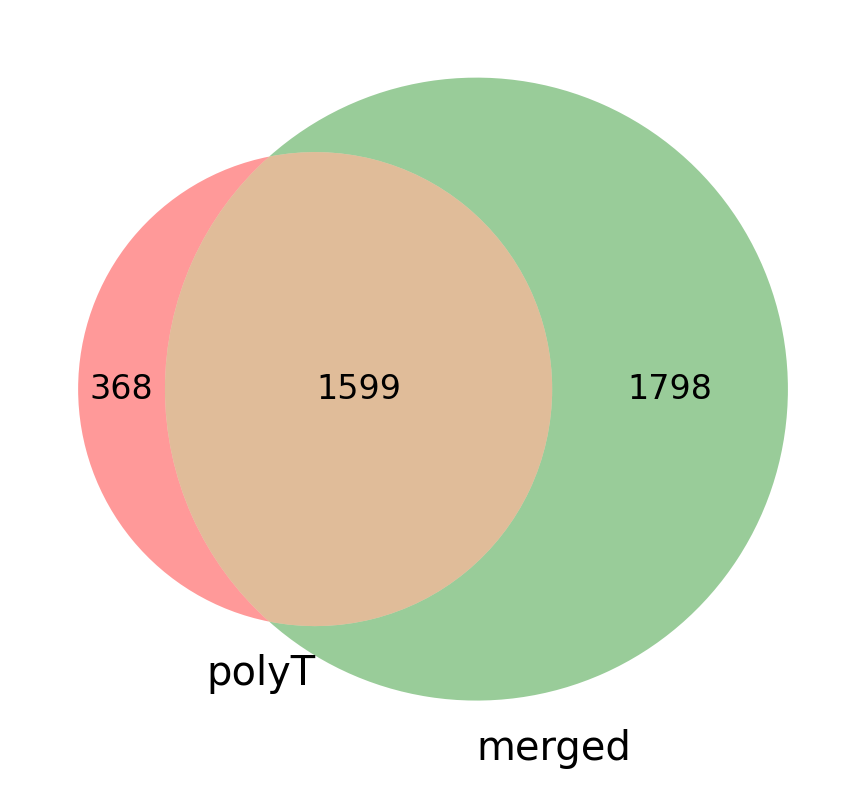

In [ ]:
#!pip install matplotlib-venn
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

aadata = [t for t in adata.obs.index]
iadata = [t for t in Iadata.obs.index]

venn2((set(aadata), set(iadata)), ('polyT', 'merged'))

In [ ]:
intersect_g = [gene for gene in adata.var.index if gene in Iadata.var.index]
intersectsc = [t for t in adata.obs.index if t in Iadata.obs.index]

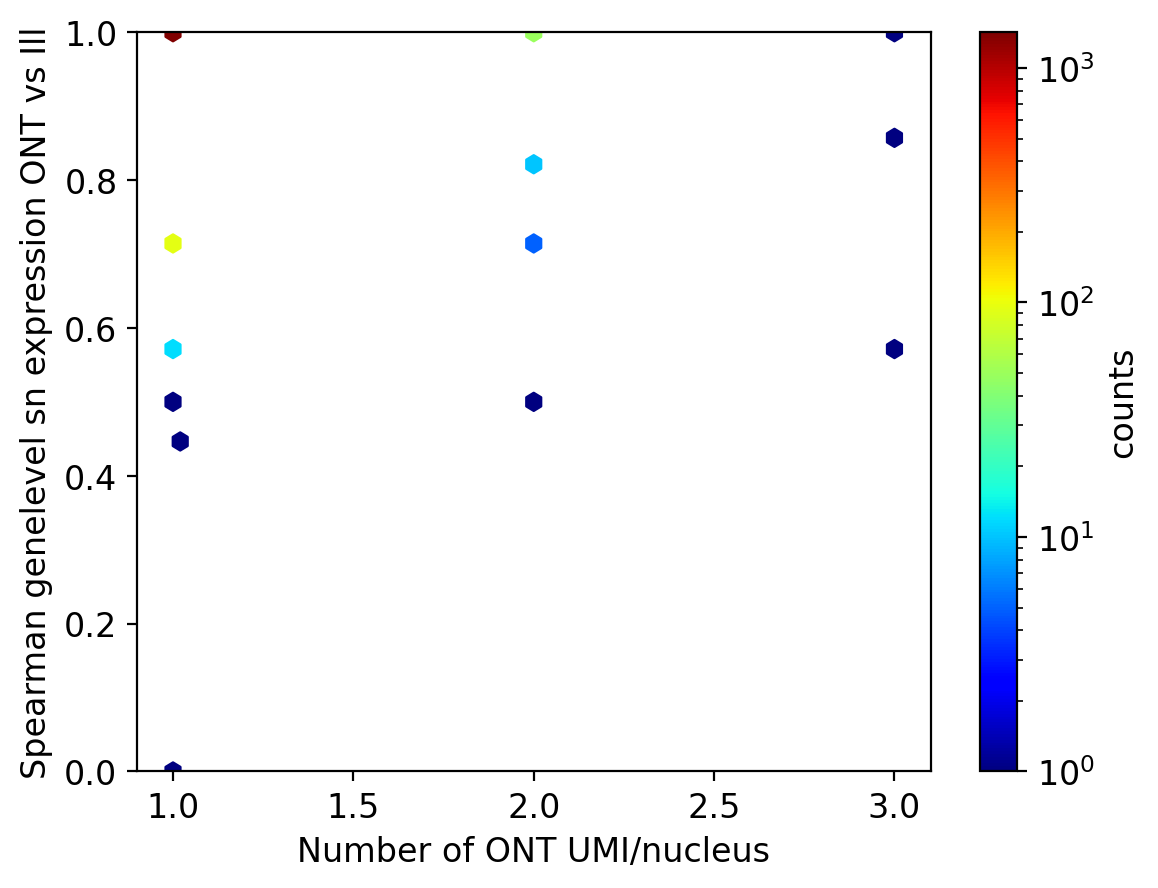

In [ ]:
adata[intersectsc, intersect_g]
spearman_gene_ONT_vs_Ill = []
for c in intersectsc:
    if np.squeeze(np.asarray(adata[c, intersect_g].X.todense())).all() != 1:
        spearman=scipy.stats.spearmanr(np.squeeze(np.asarray(adata[c, intersect_g].X.todense())), np.squeeze(np.asarray(Iadata[c, intersect_g].X.todense())))
        spearman_gene_ONT_vs_Ill.append(spearman[0])

#plt.scatter(adata.obs['n_counts'], spearman_gene_ONT_vs_Ill)
plt.hexbin(adata[intersectsc, intersect_g].obs['n_counts'], spearman_gene_ONT_vs_Ill, gridsize=50, cmap='jet', bins='log')
plt.ylabel("Spearman genelevel sn expression ONT vs Ill")
plt.xlabel("Number of ONT UMI/nucleus")
plt.ylim((0,1))
plt.colorbar(label='counts')
plt.show()

In [ ]:
%%time
!git clone https://github.com/pachterlab/kallisto.git
!ls kallisto
!mkdir kallisto/build
!ls kallisto
!ls kallisto/ext/htslib/
!cd kallisto/ext/htslib; autoheader; autoconf
!cd kallisto/build; cmake .. -DMAX_KMER_SIZE=64 -; make

Cloning into 'kallisto'...
remote: Enumerating objects: 8684, done.
remote: Counting objects: 100% (1766/1766), done.
remote: Compressing objects: 100% (506/506), done.
remote: Total 8684 (delta 1320), reused 1563 (delta 1258), pack-reused 6918 (from 1)
Receiving objects: 100% (8684/8684), 9.34 MiB | 14.05 MiB/s, done.
Resolving deltas: 100% (5746/5746), done.
astyle.txt	ext	    gen_release.sh  INSTALL.md	 README.md  test
CMakeLists.txt	func_tests  gulpfile.js     license.txt  src	    unit_tests
astyle.txt  CMakeLists.txt  func_tests	    gulpfile.js  license.txt  src   unit_tests
build	    ext		    gen_release.sh  INSTALL.md	 README.md    test
bcf_sr_sort.c  hfile_gcs.c	 htslib.pc.in	 plugin.c	      tbx.c
bcf_sr_sort.h  hfile_internal.h  htslib_vars.mk  probaln.c	      test
bgzf.c	       hfile_libcurl.c	 INSTALL	 README		      textutils.c
bgzip.c        hfile_net.c	 kfunc.c	 README.md	      thread_pool.c
config.mk.in   hfile_s3.c	 knetfile.c	 realn.c	      thread_pool_internal.h
config